# Notebook 2B - CIFAR-10 (D3) Data Preparation and Sharpening
In this notebook the trained 4x image sharpening GAN from notebook 2 will be used to sharpen several subsets of the CIFAR10 32x32 pixel dataset, to create 128x128 SR datasets for use with neural network classifiers. The sharpened and shuffled CIFAR10 LR and SR datasets and associated labels will be an output from this notbook, which can be used in notebook 4 for training several neural network classifiers. 

**Notes:** 
* **1.** The sharpened images occupy significantly more memory than the 32x32 images, as the sharpened 128x128 pixel images have 16x more pixels and also they are in floating point format, after output from the GAN, which consumes much more RAM than integer values.

* **2.** Sharpening the CIFAR10 images with a CPU would take in excess of 12 hours. The Kaggle notbook CPU environment times out after 12 hours, therefore GPU acceleration will be required for this notebook environment to sharpen the images in a quicker time that is under 12 hours. Sharpening the CIFAR10 images with the GAN takes several minutes with GPU acceleration, but the GPU only has 16BG RAM available, which restricts the amount of images that can be sharpened. This is why a 15,000 image subset of the CIFAR10 training data will be used and a second subset of 5,000 images from the CIFAR10 training data will be used for the validation data. Using these subsets allows the GPU to work without the notebook environment crashing due to an out of memory (OOM) error. The full CIFAR10 10,000 image test dataset will be sharpened also in this notebook.

**Image Sharpening GAN use policy:** Do not use the image sharpening GAN from within this notebook without express permission from the owner (github.com/D-Data8) . Please do not use the image sharpening GAN with any inappropriate or illegal images, or any images that you do not have permission to sharpen.

# 1. Import Required Libraries and Display Notebook Information

In [1]:
# Import libraries:
import tensorflow as tf
import numpy as np
from sklearn.utils import shuffle
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import time

In [2]:
# Print out the tensorflow version being used in this notebook environment:
print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.6.4


In [3]:
# Print out the processor being used for this notebook environment:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1862149931114873432,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16149905408
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1015743400531204877
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

# 2. Download CIFAR10 Data and Create Data Subsets
Firstly some functions will be defined to help balance the classes of the subsets of data taken from the full 50,000 CIFAR10 training dataset. From the full training dataset of 50,000 images, 15,000 images and labels will be used for training and 5,000 additional images and labels will be used for validation. It is important that these subsets from the full training data contain balanced classes of the 10 CIFAR10 classes, otherwise the neural network classifiers will be trained on unbalanced data and this will result in biased models. 

In [6]:
def extract_balanced_classes(images, labels, total_samples):
    balanced_images = []
    balanced_labels = []
    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)
    print("No. of classes:", num_classes)
    images_per_class = int(total_samples/num_classes)
    print("Images per class:", images_per_class)
    for classification in unique_labels:
        indices = np.where(labels == classification)
        indices = indices[0] # As np.where() returns a 2D array
        indices_reduced = indices[:int(images_per_class)]
        for index in indices_reduced:
            balanced_images.append(images[index])   
            balanced_labels.append(labels[index])  
    return balanced_images, balanced_labels

def class_counter(input_labels, name):  
    num_samples = len(input_labels)
    print("Total Number of elements in input dataset:", num_samples)
    classes = np.unique(input_labels)
    print("Dataset Unique Classes:", classes)
    class_counts = {}
    # Create the dictionary entries based on the number of classes in the input data:
    for element in classes:
        class_counts[element] = 0
    # Increment each created dictionary entry based on the input label:
    for i in input_labels:
        class_counts[i.item()] += 1
    print(name, "class counts: \n", class_counts)
    return 

In [7]:
(x_train_cifar10, y_train_cifar10), (x_test_cifar10, y_test_cifar10) = tf.keras.datasets.cifar10.load_data()

# Pick 15000 samples with balanced classes for the train data:
x_train_bal, y_train_bal = extract_balanced_classes(x_train_cifar10[:16000], 
                                                    y_train_cifar10[:16000], total_samples=15_000)

# Pick 5000 samples with balanced classes for the validation data:
x_val_bal, y_val_bal = extract_balanced_classes(x_train_cifar10[16000:22_000], 
                                                y_train_cifar10[16000:22_000], 
                                                total_samples = 5_000)
print("--------------------")
print("x_train_bal shape:", np.shape(x_train_bal))
print("y_train_bal shape:", np.shape(y_train_bal))
print("x_val_bal shape:", np.shape(x_val_bal))
print("y_val_bal shape:", np.shape(y_val_bal))
print("x_test_cifar10 shape:", np.shape(x_test_cifar10))
print("y_test_cifar10 shape:", np.shape(y_test_cifar10))

print("--------------------")
print("Counting classes in each balanced LR 32x32 CIFAR10 dataset:")
print("--------------------")
class_counter(y_train_bal, "y_train balanced")
print("--------------------")
class_counter(y_val_bal, "y_val balanced")
print("--------------------")
class_counter(y_test_cifar10, "y_test_cifar10")

170508288/170498071 [==============================] - 11s 0us/step
No. of classes: 10
Images per class: 1500
No. of classes: 10
Images per class: 500
--------------------
x_train_bal shape: (15000, 32, 32, 3)
y_train_bal shape: (15000, 1)
x_val_bal shape: (5000, 32, 32, 3)
y_val_bal shape: (5000, 1)
x_test_cifar10 shape: (10000, 32, 32, 3)
y_test_cifar10 shape: (10000, 1)
--------------------
Counting classes in each balanced LR 32x32 CIFAR10 dataset:
--------------------
Total Number of elements in input dataset: 15000
Dataset Unique Classes: [0 1 2 3 4 5 6 7 8 9]
y_train balanced class counts: 
 {0: 1500, 1: 1500, 2: 1500, 3: 1500, 4: 1500, 5: 1500, 6: 1500, 7: 1500, 8: 1500, 9: 1500}
--------------------
Total Number of elements in input dataset: 5000
Dataset Unique Classes: [0 1 2 3 4 5 6 7 8 9]
y_val balanced class counts: 
 {0: 500, 1: 500, 2: 500, 3: 500, 4: 500, 5: 500, 6: 500, 7: 500, 8: 500, 9: 500}
--------------------
Total Number of elements in input dataset: 10000
Datase

From the output of the above cell, it is clear that all datasets contain balanced classes and appear to be of the correct shape. Next, these image datasets and labels will be shuffled, then scaled so the pixel values are in the range [0,1].

In [8]:
# Shuffle all of the data while keeping all images and labels synchronised:
x_train_bal, y_train_bal = shuffle(x_train_bal, y_train_bal, random_state=7889)
x_val_bal, y_val_bal = shuffle(x_val_bal, y_val_bal, random_state=7889)
x_test_cifar10, y_test_cifar10 = shuffle(x_test_cifar10, y_test_cifar10, random_state=7889)

In [9]:
# Shuffled data shape:
print("x_train_bal shape:", np.shape(x_train_bal))
print("y_train_bal shape:", np.shape(y_train_bal))
print("x_val_bal shape:", np.shape(x_val_bal))
print("y_val_bal shape:", np.shape(y_val_bal))
print("x_test_cifar10 shape:", np.shape(x_test_cifar10))
print("y_test_cifar10 shape:", np.shape(y_test_cifar10))

# Print out the max and min pixel values for each dataset:
print("------------------------------")
print("Pixel Values Before Scaling:")
print("x_train:","Max:", np.max(x_train_bal), ", Min:", np.min(x_train_bal))
print("x_val_bal:", "Max:", np.max(x_val_bal), ", Min:", np.min(x_val_bal))
print("x_test_cifar10:", "Max:", np.max(x_test_cifar10), ", Min:", np.min(x_test_cifar10))

# Scale the image data into the range [0,1] before sharpening it with the GAN:
processed_x_train_32 = [x/255.0 for x in x_train_bal]
processed_x_val_32 = [x/255.0 for x in x_val_bal]
processed_x_test_32 = x_test_cifar10.astype('float32')/255

print("------------------------------")
print("Pixel Values After Scaling:")
print("processed_x_train_32:","Max:", np.max(processed_x_train_32),", Min:", np.min(processed_x_train_32))
print("processed_x_val_32:  ", "Max:", np.max(processed_x_val_32), ", Min:", np.min(processed_x_val_32))
print("processed_x_test_32: ", "Max:", np.max(processed_x_test_32), ", Min:", np.min(processed_x_test_32))

x_train_bal shape: (15000, 32, 32, 3)
y_train_bal shape: (15000, 1)
x_val_bal shape: (5000, 32, 32, 3)
y_val_bal shape: (5000, 1)
x_test_cifar10 shape: (10000, 32, 32, 3)
y_test_cifar10 shape: (10000, 1)
------------------------------
Pixel Values Before Scaling:
x_train: Max: 255 , Min: 0
x_val_bal: Max: 255 , Min: 0
x_test_cifar10: Max: 255 , Min: 0
------------------------------
Pixel Values After Scaling:
processed_x_train_32: Max: 1.0 , Min: 0.0
processed_x_val_32:   Max: 1.0 , Min: 0.0
processed_x_test_32:  Max: 1.0 , Min: 0.0


From the output of the above cell, the datasets shapes look correct and pixel values are in the range [0,1].

# 3. Sharpen Images with the GAN 
Now the image sharpening GAN will be imported into this notebook from the output of notebook 2 and the train, validation and test datasets will be sharpened with it to create the 128x128 CIFAR10 SR datasets.

In [ ]:
# Download the image sharpening GAN from notebook 2 output:
path = "../input/2-cats-dogs-gan-training-v1/cat_dog_17077_images_trained_generator_20_epochs.h5"
sharpening_GAN = tf.keras.models.load_model(path)

In [10]:
# Sharpen the LR training images:
T1 = time.time()
x_train_128 = sharpening_GAN.predict(np.array(processed_x_train_32))
T2 = time.time() - T1
print("Sharpening took {} minutes".format(T2/60))

Sharpening took 0.6144552906354268 minutes


In [11]:
# Sharpen the LR validation images:
T1 = time.time()
x_val_128 = sharpening_GAN.predict(np.array(processed_x_val_32))
T2 = time.time() - T1
print("Sharpening took {} minutes".format(T2/60))

Sharpening took 0.17592630783716837 minutes


In [13]:
# Sharpen the LR test images:
T1 = time.time()
x_test_128 = sharpening_GAN.predict(np.array(processed_x_test_32))
T2 = time.time() - T1
print("Sharpening took {} minutes".format(T2/60))

Sharpening took 0.35107455650965375 minutes


In [11]:
print("x_train_128:", np.shape(x_train_128), ", Min:", np.min(x_train_128), ", Max:", np.max(x_train_128))
print("x_val_128:  ", np.shape(x_val_128), ",  Min:", np.min(x_val_128), ", Max:", np.max(x_val_128))
print("x_test_128: ", np.shape(x_test_128), ", Min:", np.min(x_test_128), ", Max:", np.max(x_test_128))

x_train_128: (15000, 128, 128, 3) , Min: -0.46160197 , Max: 1.3437979
x_val_128:   (5000, 128, 128, 3) ,  Min: -0.23701528 , Max: 1.3279649
x_test_128:  (10000, 128, 128, 3) , Min: -0.36734226 , Max: 1.3385725


Based on the output from the previous cell, it can be seen that the GAN has prouduced images were the pixel values extend beyond [0,1], therefore these pixels will be clipped to [0,1].

In [12]:
# Clip the pixel values into the range of [0,1] for all three datasets:
x_train_128 = tf.clip_by_value(x_train_128, 0, 1)
x_val_128 = tf.clip_by_value(x_val_128, 0, 1)
x_test_128 = tf.clip_by_value(x_test_128, 0, 1)

# Now print out the same metrics after the pixel vaules have been clipped to [0,1]:
print("x_train_128:", np.shape(x_train_128), ", Min:", np.min(x_train_128), ", Max:", np.max(x_train_128))
print("x_val_128:  ", np.shape(x_val_128), ",  Min:", np.min(x_val_128), ", Max:", np.max(x_val_128))
print("x_test_128: ", np.shape(x_test_128), ", Min:", np.min(x_test_128), ", Max:", np.max(x_test_128))

x_train_128: (15000, 128, 128, 3) , Min: 0.0 , Max: 1.0
x_val_128:   (5000, 128, 128, 3) ,  Min: 0.0 , Max: 1.0
x_test_128:  (10000, 128, 128, 3) , Min: 0.0 , Max: 1.0


## 3.1 Verify Sharpened Images 
The train, validation and test sharpened images will be plotted so that it can be verified that the labels and images are synchronised across all datasets and that the sharpened images look correct.

In [13]:
# Create a dictionary of the CIFAR10 associated label names:
cifar10_label_names = {0:"Airplane", 1:"Automobile", 2:"Bird", 3:"Cat", 4:"Deer", 5:"Dog",
                       6:"Frog", 7:"Horse", 8:"Ship", 9:"Truck"}

## 3.1.1 Train Images

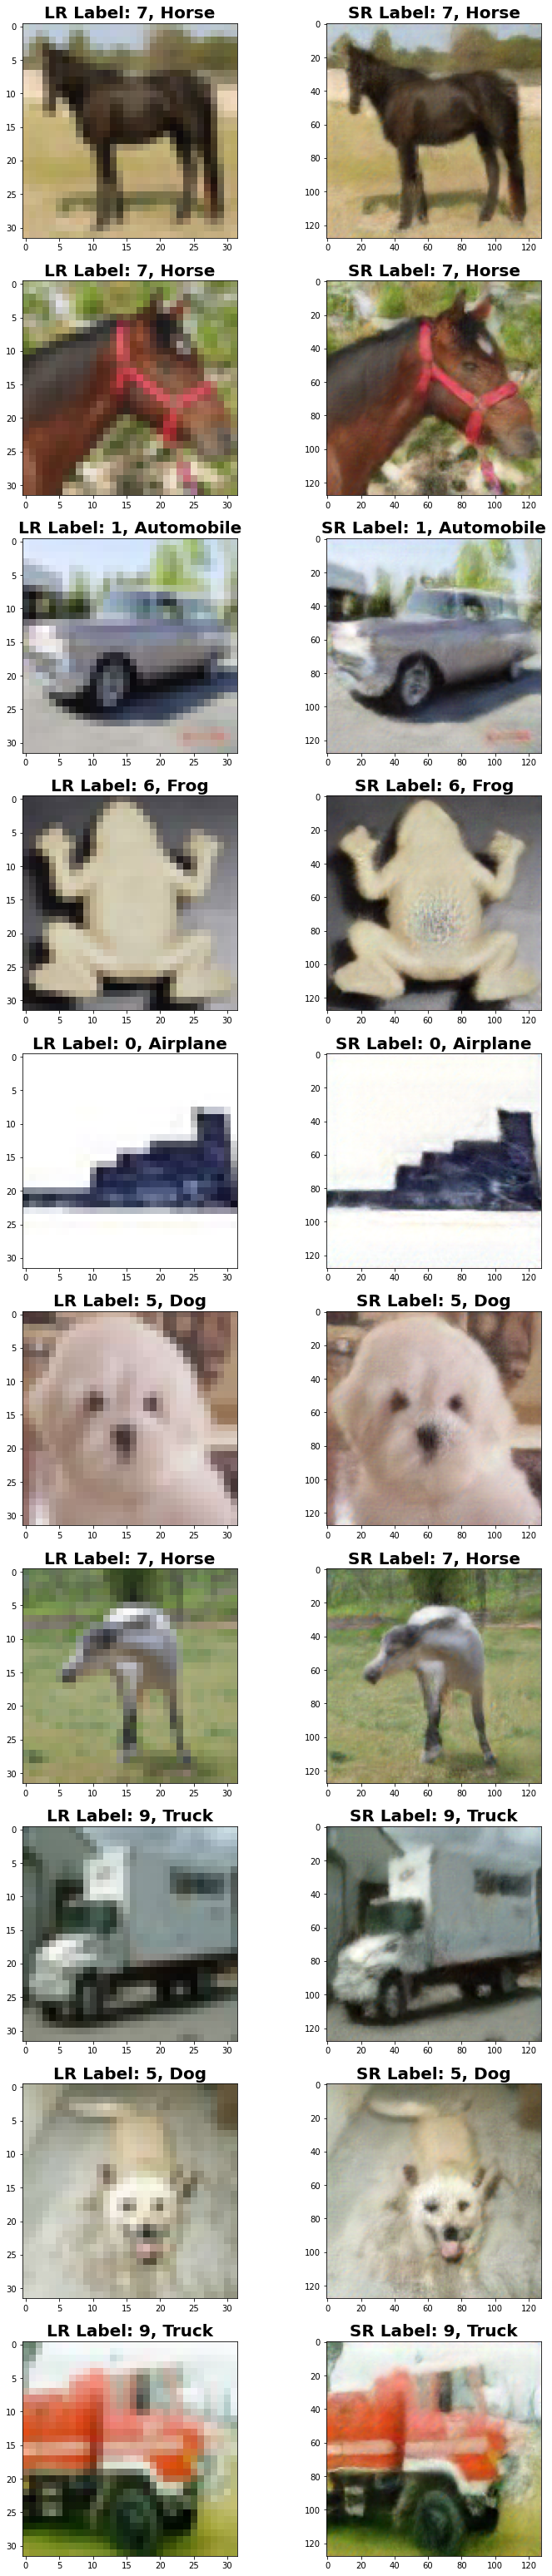

In [14]:
# Plot some of the training data and associated labels:   
fig, ax = plt.subplots(nrows=6,ncols=2, figsize=(12,56))
np.random.seed(7889)
for image in range(0, 19, 2):
    random_train_index = int(np.random.randint(low = 1, high = 5_000, size = 1))
    plt.subplot(10,2,image+1)
    plt.imshow(processed_x_train_32[random_train_index])
    label = int(y_train_bal[random_train_index])
    label_text = cifar10_label_names[label]
    plt.title("LR Label: {}, {}".format(label, label_text), fontsize=20, fontweight='bold')
    plt.subplot(10,2,image+2)
    plt.imshow(x_train_128[random_train_index])
    plt.title("SR Label: {}, {}".format(label, label_text), fontsize=20, fontweight='bold')

## 3.1.2 Validation Images

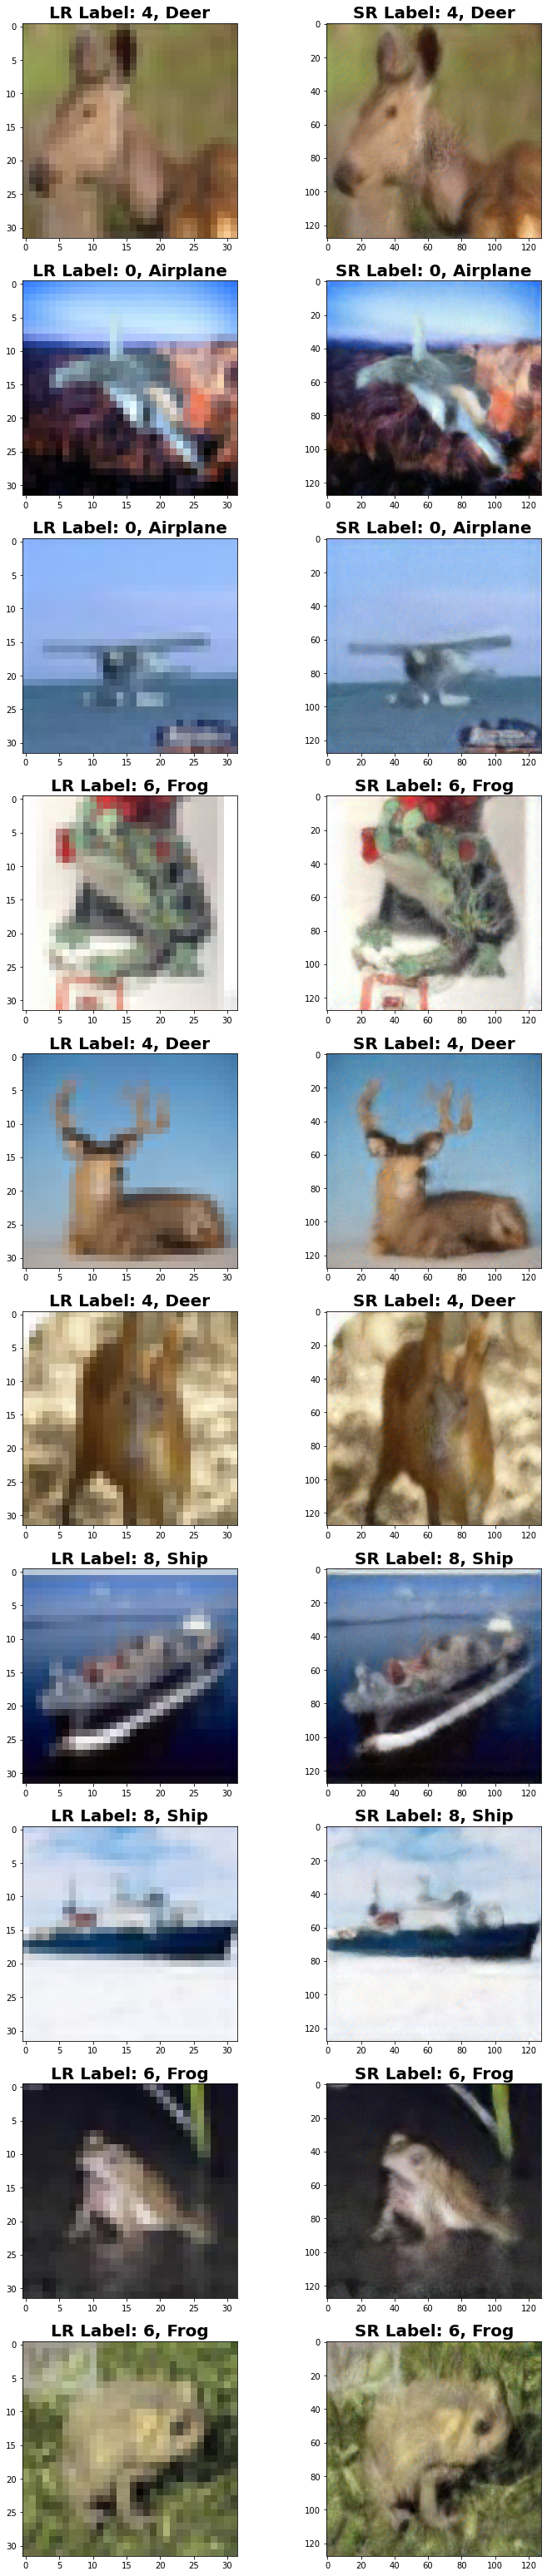

In [15]:
# Plot some of the validation data and associated labels:   
fig, ax = plt.subplots(nrows=6,ncols=2, figsize=(12,56))
np.random.seed(7889)
for image in range(0, 19, 2):
    random_val_index = int(np.random.randint(low = 1, high = 5_000, size = 1))
    plt.subplot(10,2,image+1)
    plt.imshow(processed_x_val_32[random_val_index])
    label = int(y_val_bal[random_val_index])
    label_text = cifar10_label_names[label]
    plt.title("LR Label: {}, {}".format(label, label_text), fontsize=20, fontweight='bold')
    plt.subplot(10,2,image+2)
    plt.imshow(x_val_128[random_val_index])
    plt.title("SR Label: {}, {}".format(label, label_text), fontsize=20, fontweight='bold')

## 3.1.3 Test Images

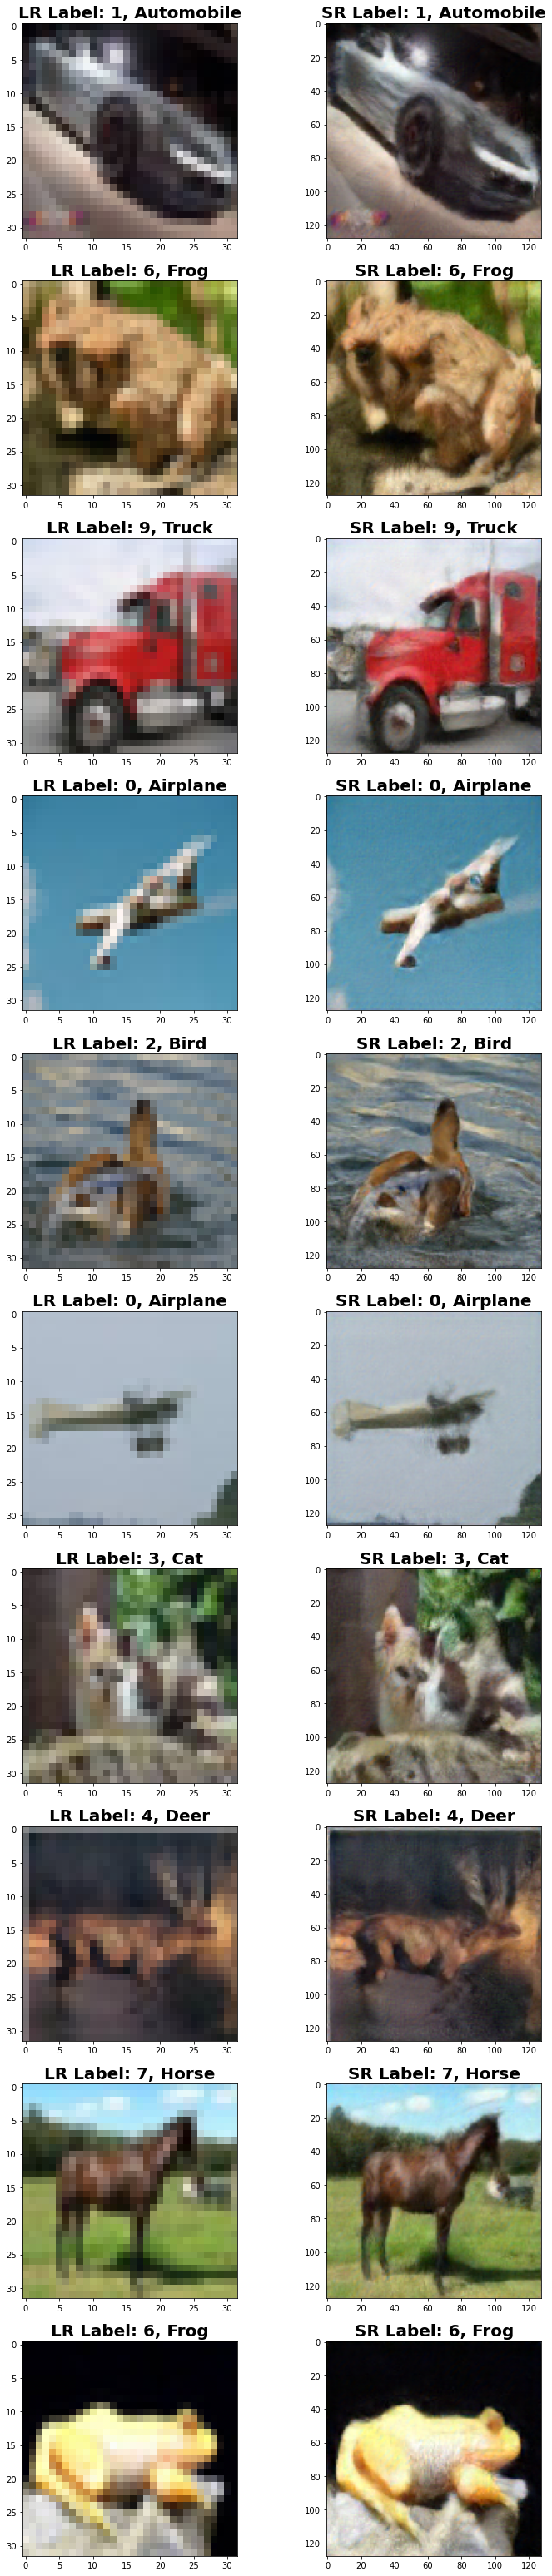

In [16]:
# Plot some of the test data and associated labels:   
fig, ax = plt.subplots(nrows=10,ncols=2, figsize=(12,56))
np.random.seed(7889)
for image in range(0, 19, 2):
    random_test_index = int(np.random.randint(low = 1, high = 10_000, size = 1))
    plt.subplot(10,2,image+1)
    plt.imshow(processed_x_test_32[random_test_index])
    label = int(y_test_cifar10[random_test_index])
    label_text = cifar10_label_names[label]
    plt.title("LR Label: {}, {}".format(label, label_text), fontsize=20, fontweight='bold')
    plt.subplot(10,2,image+2)
    plt.imshow(x_test_128[random_test_index])
    plt.title("SR Label: {}, {}".format(label, label_text), fontsize=20, fontweight='bold')

From the above plots from the three subsets; training, validation and test, it is clear that the data and labels are synchronised across all datsets. Each of the 10 randomly sampled images from the three datasets contain the correct item, according to the labels. This verifies that the images and labels are synchronised across all three datasets.

It is also clear that the sharpened images are 128x128 pixels in size, depict a sharper version of the CIFAR10 data and the colours all look correct. Now the data subsets can be saved for export to notebook 4, where they will be used to train the LR and SR neural network classifiers.

## 3.2 Save the LR and SR CIFAR10 Datasets 
Save both LR and SR datsets and associated labels so that they can be used as input in notebook 4.

In [17]:
# Download LR CIFAR10 32x32 datasets so they can be used in notebook 4:
np.savez('CIFAR10_x_train_32', processed_x_train_32)
np.savez('CIFAR10_x_val_32', processed_x_val_32)
np.savez('CIFAR10_x_test_32', processed_x_test_32)
np.savez('CIFAR10_y_train_32', y_train_bal)
np.savez('CIFAR10_y_val_32', y_val_bal)
np.savez('CIFAR10_y_test_32', y_test_cifar10)

In [ ]:
# Save the sharpened image datasets & Associated Labels:
np.savez("x_train_128_saved_15k", x_train_128)
np.savez("x_val_128_saved_5k", x_val_128)
np.savez("x_test_128_saved_10k", x_test_128)
np.savez("y_train_128_labels_15k", y_train_bal)
np.savez("y_val_128_labels_5k", y_val_bal)
np.savez("y_test_128_labels_10k", y_test_cifar10)

## 3.4 Download the Saved Datasets
The code in the following cells allows each saved dataset to be downloaded to a local machine for external backup.

In [ ]:
import os
os.chdir(r'../working')

from IPython.display import FileLink
FileLink(r'x_train_128_saved_15k.npz')

In [ ]:
FileLink(r'y_train_128_labels_15k.npz')


In [ ]:
FileLink(r'x_val_128_saved_5k.npz')

In [ ]:
FileLink(r'y_val_128_labels_5k.npz')

In [ ]:
FileLink(r'x_test_128_saved_10k.npz')

In [ ]:
FileLink(r'y_test_128_labels_10k.npz')